# Current constituents of VN30


In [ ]:
#importing packages
import pandas as pd
import numpy as np
import datetime as dt
import pandas_datareader as pdr
import seaborn as sns
import matplotlib.pyplot as plt
import bs4 as bs
import requests
from IPython.display import clear_output
from scipy.stats import mstats
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import RandomizedSearchCV, validation_curve, TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
import pickle
import os
from sklearn.model_selection import GridSearchCV
sns.set()

In [ ]:
all_data = pd.read_csv("VN30_data.csv", index_col=0, parse_dates=True)
all_data

,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_15,SMA_ratio,...,ADX_15,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,21758.0,21903.0,21541.0,21686.0,183398,ACB,0.010155,21607.2,20971.000000,0.970556,...,25.093592,45.034483,72.526715,68.308864,59.549210,1.147099,68.712603,62.903213,1.092354,515.231459
2007-01-04,22338.0,22483.0,21758.0,22483.0,342745,ACB,0.036752,21830.6,21116.000000,0.967266,...,25.703732,100.000000,100.000000,69.677010,63.185447,1.102738,81.871143,68.653723,1.192523,655.267330
2007-01-05,22628.0,23209.0,22483.0,22846.0,346181,ACB,0.016146,22048.2,21284.266667,0.965352,...,26.701074,80.752916,89.991729,70.825870,67.090601,1.055675,85.373348,70.858164,1.204848,785.277116
2007-01-08,22773.0,23209.0,22048.0,22701.0,228067,ACB,-0.006347,22236.8,21414.800000,0.963034,...,27.078960,73.064687,85.993934,70.437084,69.642131,1.011415,77.862786,68.787792,1.131927,798.187944
2007-01-09,22773.0,22919.0,22338.0,22628.0,210028,ACB,-0.003216,22468.8,21530.800000,0.958253,...,27.431653,65.167866,83.981252,72.803990,71.377526,1.019985,73.778245,67.720467,1.089453,757.253097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,34650.0,34900.0,33150.0,34000.0,12182800,VRE,-0.025788,34220.0,34620.000000,1.011689,...,11.822802,36.956522,31.325301,59.885884,52.557598,1.139433,43.861083,50.799622,0.863414,55.787953
2022-02-25,34400.0,34500.0,34000.0,34000.0,4080500,VRE,0.000000,34300.0,34556.666667,1.007483,...,11.259089,36.956522,31.325301,58.496701,49.535255,1.180910,43.861083,50.799622,0.863414,-14.422548
2022-02-28,34000.0,34200.0,33500.0,33500.0,5203100,VRE,-0.014706,34180.0,34423.333333,1.007119,...,11.087806,15.217391,20.000000,47.881643,45.421543,1.054162,35.174406,48.262017,0.728822,-158.944401


In [ ]:
len(set(all_data['Symbol']))

29

In [ ]:
print(set(all_data['Symbol']))

{'PDR', 'VRE', 'MSN', 'GVR', 'CTG', 'POW', 'VPB', 'ACB', 'SSI', 'TPB', 'PLX', 'NVL', 'VCB', 'HDB', 'MBB', 'MWG', 'GAS', 'KDH', 'PNJ', 'VNM', 'TCB', 'BVH', 'VIC', 'FPT', 'BID', 'HPG', 'VHM', 'SAB', 'VJC'}


# Creating Prediction variable

Now that we have formed all the variables that will be used in predicting the stock movement, we need to define the prediction variable.
Technical Indicators generally work well in short interval predictions and since our indicators have been based on 5-day and 15-day periods, I use a 7 (trading) days prediction interval. Thus, the idea is to observe the technical indicators for today and use it to predict the direction of movement of the stocks 7 days later. If the stock went up in 7 days, we denote it by 1 and if it went down/did not change, we denote it by 0 (“Target_Direction”). In order to make this even more comprehensive, let us look at it from a real-world point of view. If we look at the indicators today, we will buy the next day’s opening price and hold for 7 trading days, including the day we bought, and sell at the Closing 7 days later. Thus, in our code, we will have to shift the price by just 6 days. Our profit will be the difference between our buy (Opening price of day 1) and sell (Closing price of day 7)
In the below code, we define the Target variable as the percentage profit defined above. This is transformed into a Target Direction (1 or 0) variable as described above, which forms our prediction variable.


In [ ]:
Target_variables = ['SMA_ratio','ATR_5','ATR_15','ATR_Ratio',
                       'ADX_5','ADX_15','SMA_Volume_Ratio','Stochastic_5','Stochastic_15','Stochastic_Ratio',
                      'RSI_5','RSI_15','RSI_ratio','MACD']
for variable in Target_variables:
    all_data.loc[:,variable] = mstats.winsorize(all_data.loc[:,variable], limits = [0.1,0.1])

In [ ]:
all_data

,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_15,SMA_ratio,...,ADX_15,Stochastic_5,Stochastic_15,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,21758.0,21903.0,21541.0,21686.0,183398,ACB,0.010155,21607.2,20971.000000,0.970556,...,25.093592,45.034483,72.526715,68.308864,59.549210,1.147099,68.712603,62.903213,1.092354,515.231459
2007-01-04,22338.0,22483.0,21758.0,22483.0,342745,ACB,0.036752,21830.6,21116.000000,0.967266,...,25.703732,92.329280,91.438122,69.677010,63.185447,1.102738,79.824566,68.496611,1.192523,655.267330
2007-01-05,22628.0,23209.0,22483.0,22846.0,346181,ACB,0.016146,22048.2,21284.266667,0.965352,...,26.701074,80.752916,89.991729,70.825870,67.090601,1.055675,79.824566,68.496611,1.204848,785.277116
2007-01-08,22773.0,23209.0,22048.0,22701.0,228067,ACB,-0.006347,22236.8,21414.800000,0.963034,...,27.078960,73.064687,85.993934,70.437084,69.642131,1.011415,77.862786,68.496611,1.131927,798.187944
2007-01-09,22773.0,22919.0,22338.0,22628.0,210028,ACB,-0.003216,22468.8,21530.800000,0.961256,...,27.431653,65.167866,83.981252,72.803990,71.377526,1.019985,73.778245,67.720467,1.089453,757.253097
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-24,34650.0,34900.0,33150.0,34000.0,12182800,VRE,-0.025788,34220.0,34620.000000,1.011689,...,13.815142,36.956522,31.325301,59.885884,52.557598,1.139433,43.861083,50.799622,0.863414,55.787953
2022-02-25,34400.0,34500.0,34000.0,34000.0,4080500,VRE,0.000000,34300.0,34556.666667,1.007483,...,13.815142,36.956522,31.325301,58.496701,49.535255,1.180910,43.861083,50.799622,0.863414,-14.422548
2022-02-28,34000.0,34200.0,33500.0,33500.0,5203100,VRE,-0.014706,34180.0,34423.333333,1.007119,...,13.815142,15.217391,20.000000,47.881643,45.421543,1.054162,35.174406,48.262017,0.728822,-158.944401


In [ ]:
len(set(all_data['Symbol']))

29

# Winsorizing the Indicators

In [ ]:
all_data['Close_Shifted'] = all_data.groupby('Symbol')['Close'].transform(lambda x: x.shift(-6))
all_data['Target'] = ((all_data['Close_Shifted'] - all_data['Open'])/(all_data['Open']) * 100).shift(-1)
all_data['Target_Direction'] = np.where(all_data['Target']>0,1,0)
all_data = all_data.dropna().copy()

In [ ]:
all_data

,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_15,SMA_ratio,...,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,21758.0,21903.0,21541.0,21686.0,183398,ACB,0.010155,21607.2,20971.000000,0.970556,...,68.308864,59.549210,1.147099,68.712603,62.903213,1.092354,515.231459,23238.0,5.331722,1
2007-01-04,22338.0,22483.0,21758.0,22483.0,342745,ACB,0.036752,21830.6,21116.000000,0.967266,...,69.677010,63.185447,1.102738,79.824566,68.496611,1.192523,655.267330,23529.0,4.622591,1
2007-01-05,22628.0,23209.0,22483.0,22846.0,346181,ACB,0.016146,22048.2,21284.266667,0.965352,...,70.825870,67.090601,1.055675,79.824566,68.496611,1.204848,785.277116,23674.0,4.913714,1
2007-01-08,22773.0,23209.0,22048.0,22701.0,228067,ACB,-0.006347,22236.8,21414.800000,0.963034,...,70.437084,69.642131,1.011415,77.862786,68.496611,1.131927,798.187944,23892.0,3.956440,1
2007-01-09,22773.0,22919.0,22338.0,22628.0,210028,ACB,-0.003216,22468.8,21530.800000,0.961256,...,72.803990,71.377526,1.019985,73.778245,67.720467,1.089453,757.253097,23674.0,7.643731,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-02-15,33000.0,34000.0,32700.0,34000.0,8107200,VRE,0.030303,34700.0,34110.000000,0.982997,...,34.472028,50.415762,0.683755,44.765089,51.806048,0.864090,101.808515,34900.0,-0.584795,0
2022-02-16,34200.0,34450.0,33750.0,34300.0,4748300,VRE,0.008824,34380.0,34180.000000,0.994183,...,28.318182,50.626288,0.559357,48.965481,52.980621,0.924215,89.673589,34000.0,-0.874636,0
2022-02-17,34300.0,34750.0,34000.0,34450.0,3764700,VRE,0.004373,34070.0,34236.666667,1.004892,...,25.269231,49.841032,0.506997,51.281031,53.586608,0.956975,110.108482,34000.0,-1.470588,0


In [ ]:
len(set(all_data['Symbol']))

29

# Clustering companies

This is where things start to get interesting. A simple way of predicting would be to assume that all the companies would follow the same ML model and create this one global model to predict returns for all companies. However, it is possible that different companies/industries react differently to a set of Technical Indicator. One way to solve this problem is to create different ML model for each cluster of companies that are expected to behave similarly perhaps belonging to the same industry, where the “behavior” is captured in their returns.
Thus, to make our model even more sophisticated, we will create different ML models for each cluster.

# Identify number of clusters

The idea is to use returns of these companies and create an elbow curve to determine the number of clusters that would create a balance between low sum of squares within a cluster vs the total number of clusters. For 30 companies, if we create 30 clusters, we would get 0 sum of squares within the cluster however this clustering would not make sense, i.e. would not be parsimonious. On the other hand, having 1 cluster would be parsimonious however will lead to very high sum of squares within cluster. An elbow curve helps to determine the approximate point at which the marginal decrease in sum of squares is small.
We use K-means clustering to create an elbow curve. K-means aims at minimizing the inertia or the within cluster sum of squares while clustering. By providing a range of clusters from 1 to 20, we create the required elbow curve.

In [ ]:
all_data.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Symbol', 'Return', 'SMA_5',
       'SMA_15', 'SMA_ratio', 'SMA5_Volume', 'SMA15_Volume',
       'SMA_Volume_Ratio', 'ATR_5', 'ATR_15', 'ATR_Ratio', 'ADX_5', 'ADX_15',
       'Stochastic_5', 'Stochastic_15', 'Stochastic_%D_5', 'Stochastic_%D_15',
       'Stochastic_Ratio', 'RSI_5', 'RSI_15', 'RSI_ratio', 'MACD',
       'Close_Shifted', 'Target', 'Target_Direction'],
      dtype='object')

<class 'pandas.core.frame.DataFrame'>
Index: 29 entries, ACB to VRE
Columns: 878 entries, 2018-07-16 to 2022-02-17
dtypes: float64(878)
memory usage: 200.4+ KB
None


,Difference in SS
1,NaN
2,-0.666445
3,-0.555299
4,-0.307405
5,-0.312204
6,-0.306025
7,-0.365995
8,-0.371503
9,-0.201782
10,-0.375432


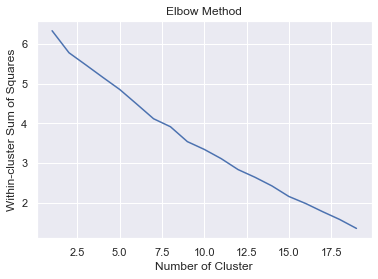

In [ ]:
#Extract the returns
returns = all_data[['Symbol','Return']].copy()
returns['Date'] = returns.index.copy()

#Pivot the returns to create series of returns for each stock
transposed = returns.pivot(index = 'Date', columns = 'Symbol', values = 'Return')

#Transpose the data to get companies on the index level and dates on the column level since clusters takes place on index level
X = transposed.dropna().transpose()
print(X.info())
#Extract sum of squares for K-means clusters from 1 to 50 clusters
n = 20
sum_of_sq = np.zeros([n, 1])

for k in range(1, n+1):
    sum_of_sq[k-1] = KMeans(n_clusters=k).fit(X).inertia_

plt.plot(range(1, n), sum_of_sq[1:n])
plt.title("Elbow Method")
plt.xlabel("Number of Cluster")
plt.ylabel("Within-cluster Sum of Squares")

pd.DataFrame(sum_of_sq, columns = ['Difference in SS'], index = range(1,n+1)).diff()

Thus, we can see from the above curves and the table that 10 clusters best serve our purpose. The decrease in sum of squares after 10 is not large enough. Hence, for our analysis, we select 10 clusters.

# Creating clusters

We now use the Guassian Mixture clustering algorithm to assign the companies to 10 clusters based on their returns. Gaussian Mixture is an uses a probabilistic method of determining the appropriate cluster for a series of observation, assuming the universe is formed out of different Gaussian distributions.
The code below provides us a dataframe with different clusters and the companies that fall in each cluster.

In [ ]:
#Get 10 clusters
gmm = GaussianMixture(n_components = 10)
gmm.fit(transposed.dropna().transpose())

#Predict for each company
clusters = gmm.predict(transposed.dropna().transpose())
clusters_df = pd.DataFrame({'Cluster':clusters,
                           'Companies':transposed.columns})

#Sort by Clusters
clusters_df = clusters_df.sort_values(['Cluster']).reset_index(drop = True)

#Save as csv
clusters_df.to_csv("clusters.csv")
clusters_df = pd.read_csv("clusters.csv", index_col = 0)

The clustering resulted in, to a large extent, an industry wide classification of stocks which is in line with our initial thought.

# Random Forest model

Random Forest is a commonly used Machine Learning model for Regression and Classification problems. However, given the complexity of the model, it is important to carefully understand the parameters that go into the model to prevent in-sample overfitting or underfitting, a standard bias-variance tradeoff.
There are quite a few things to consider while forming a Machine Learning model.

# Training period

We will first separate our data into a train and a test sample. While scipy offers a TrainTestSplit function, we will not use that here since our data is a time series data and we want to split the Train-Test as a timeline rather than randomly selecting observations as train or test. We first convert our index into a date time index and split the data to before and after 31st December 2020.
Train period: to 31st December 2020
Test period: 1st January 2021 — now

In [ ]:
all_data.index = pd.to_datetime(all_data.index)

train_data = all_data.loc[:'2020-12-31',]
test_data = all_data.loc['2021-01-01':]

In [ ]:
train_data

,Open,High,Low,Close,Volume,Symbol,Return,SMA_5,SMA_15,SMA_ratio,...,Stochastic_%D_5,Stochastic_%D_15,Stochastic_Ratio,RSI_5,RSI_15,RSI_ratio,MACD,Close_Shifted,Target,Target_Direction
Date,,,,,,,,,,,,,,,,,,,,,
2007-01-03,21758.0,21903.0,21541.0,21686.0,183398,ACB,0.010155,21607.2,20971.000000,0.970556,...,68.308864,59.549210,1.147099,68.712603,62.903213,1.092354,515.231459,23238.0,5.331722,1
2007-01-04,22338.0,22483.0,21758.0,22483.0,342745,ACB,0.036752,21830.6,21116.000000,0.967266,...,69.677010,63.185447,1.102738,79.824566,68.496611,1.192523,655.267330,23529.0,4.622591,1
2007-01-05,22628.0,23209.0,22483.0,22846.0,346181,ACB,0.016146,22048.2,21284.266667,0.965352,...,70.825870,67.090601,1.055675,79.824566,68.496611,1.204848,785.277116,23674.0,4.913714,1
2007-01-08,22773.0,23209.0,22048.0,22701.0,228067,ACB,-0.006347,22236.8,21414.800000,0.963034,...,70.437084,69.642131,1.011415,77.862786,68.496611,1.131927,798.187944,23892.0,3.956440,1
2007-01-09,22773.0,22919.0,22338.0,22628.0,210028,ACB,-0.003216,22468.8,21530.800000,0.961256,...,72.803990,71.377526,1.019985,73.778245,67.720467,1.089453,757.253097,23674.0,7.643731,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-12-25,29900.0,30600.0,29550.0,30450.0,5682560,VRE,0.016694,30340.0,29593.333333,0.975390,...,64.964017,65.760457,0.987889,61.573846,63.885559,0.963815,579.883213,33300.0,8.143322,1
2020-12-28,30700.0,30850.0,30050.0,30450.0,8216210,VRE,0.000000,30350.0,29736.666667,0.979791,...,64.225014,66.002881,0.973064,61.573846,63.885559,0.963815,545.783868,33200.0,11.330049,1
2020-12-29,30450.0,31800.0,30250.0,31650.0,11628180,VRE,0.039409,30620.0,29966.666667,0.978663,...,68.472700,69.611950,0.983634,79.610938,68.496611,1.120397,753.151589,33900.0,11.987382,1


# Validation Curves

To determine the initial values that will be given to GridSearchCV, upon which it will work to find the best combination, we can use Validation Curves for each of the parameters. Validation curves also look at cross validation and provides a score of prediction for in sample and out of sample. This provides us a good idea of the initial value around which we can provide a range to the GridSearchCV.
Below is an example of validation curve score for n_estimators. At the lowest n_estimators, we see underfitting while at higher n_estimators we see over-fitting. Underfitting leads to high bias-low variance where overfitting leads to low bias-high variance. We can see that at n=7, we obtain a good tradeoff between bias and variance. Hence in our GridSearchCV, we use n_estimators to be around 7.

Text(0.5, 1.0, 'Validation Curve Score for n_estimators')

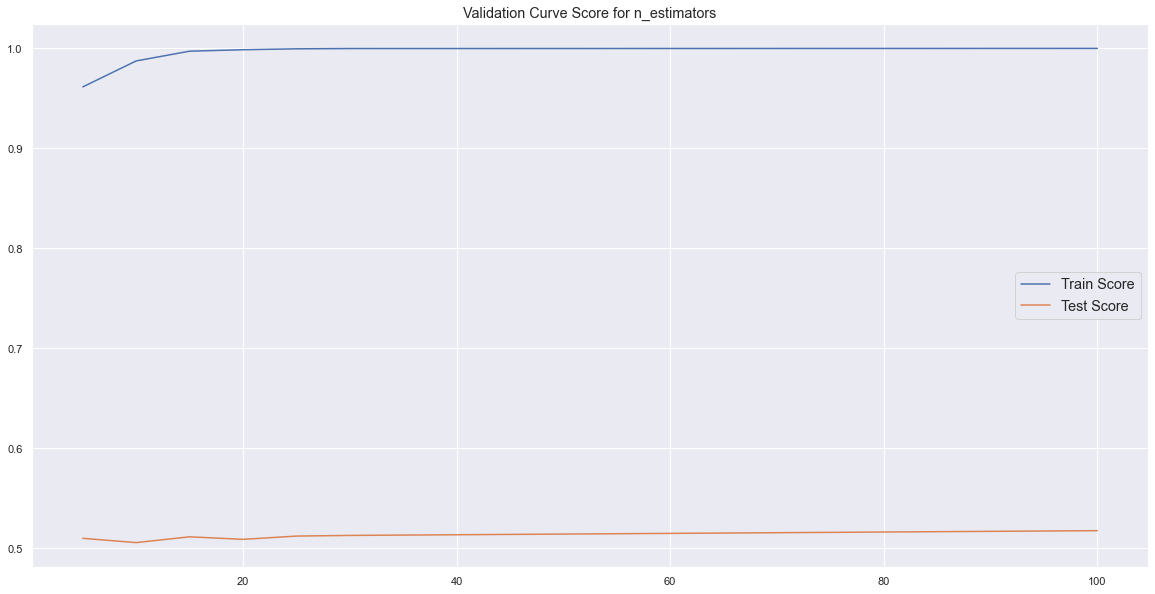

In [ ]:
#Separate between X and Y
X_train = train_data.loc[:,Target_variables]

Y_train = train_data.loc[:,['Target_Direction']]

#Create validation curve for the Random Forest Classifier
rf = RandomForestClassifier()
train_scoreNum, test_scoreNum = validation_curve(rf,
                                X = X_train.loc['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'],
                                param_name = 'n_estimators',
                                param_range = [5,10,15,20,25,30,100], cv = TimeSeriesSplit(n_splits = 3))

train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

plt.figure(figsize = (20,10))
plt.plot([5,10,15,20,25,30,100],train_scores_mean)
plt.plot([5,10,15,20,25,30,100],test_scores_mean)
plt.legend(['Train Score','Test Score'], fontsize = 'large')
plt.title('Validation Curve Score for n_estimators', fontsize = 'large')



Text(0.5, 1.0, 'Validation Curve Score for max_depth')

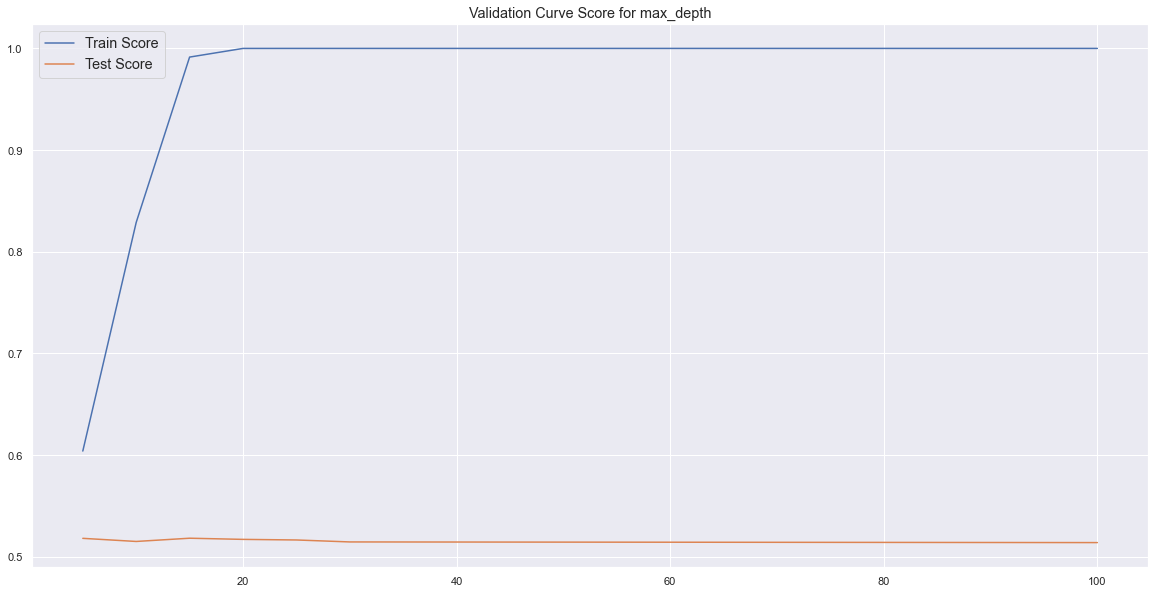

In [ ]:
#Separate between X and Y
X_train = train_data.loc[:,Target_variables]

Y_train = train_data.loc[:,['Target_Direction']]

#Create validation curve for the Random Forest Classifier
rf = RandomForestClassifier()
train_scoreNum, test_scoreNum = validation_curve(rf,
                                X = X_train.loc['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'],
                                param_name = 'max_depth',
                                param_range = [5,10,15,20,25,30,100], cv = TimeSeriesSplit(n_splits = 3))

train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

plt.figure(figsize = (20,10))
plt.plot([5,10,15,20,25,30,100],train_scores_mean)
plt.plot([5,10,15,20,25,30,100],test_scores_mean)
plt.legend(['Train Score','Test Score'], fontsize = 'large')
plt.title('Validation Curve Score for max_depth', fontsize = 'large')



Text(0.5, 1.0, 'Validation Curve Score for min_samples_leaf')

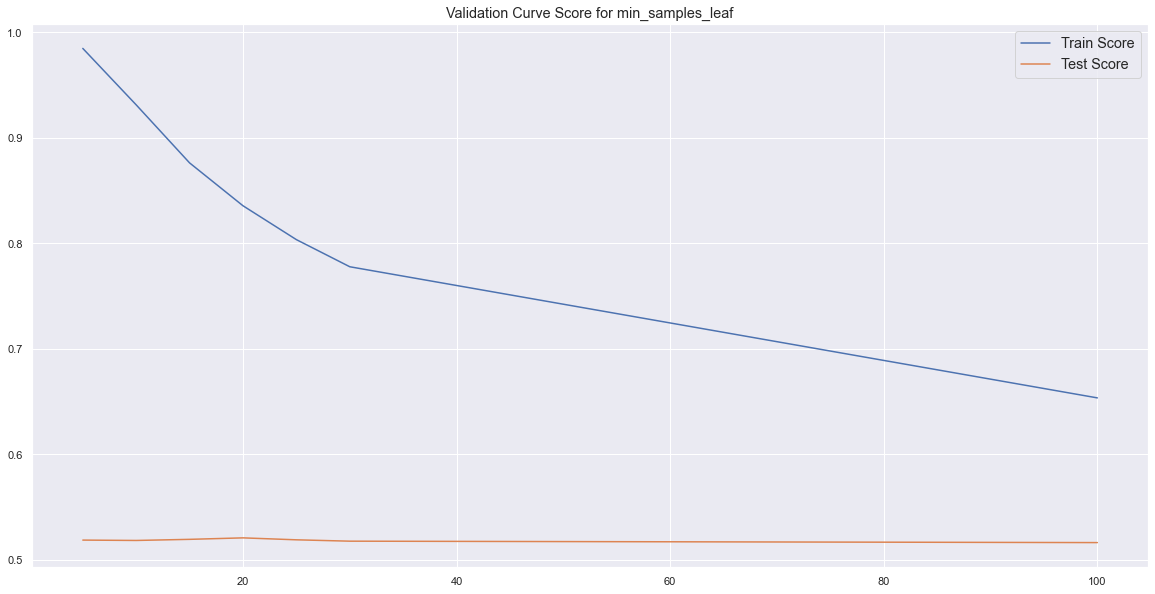

In [ ]:
#Separate between X and Y
X_train = train_data.loc[:,Target_variables]

Y_train = train_data.loc[:,['Target_Direction']]

#Create validation curve for the Random Forest Classifier
rf = RandomForestClassifier()
train_scoreNum, test_scoreNum = validation_curve(rf,
                                X = X_train.loc['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'],
                                param_name = 'min_samples_leaf',
                                param_range = [5,10,15,20,25,30,100], cv = TimeSeriesSplit(n_splits = 3))

train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

plt.figure(figsize = (20,10))
plt.plot([5,10,15,20,25,30,100],train_scores_mean)
plt.plot([5,10,15,20,25,30,100],test_scores_mean)
plt.legend(['Train Score','Test Score'], fontsize = 'large')
plt.title('Validation Curve Score for min_samples_leaf', fontsize = 'large')



Text(0.5, 1.0, 'Validation Curve Score for min_samples_split')

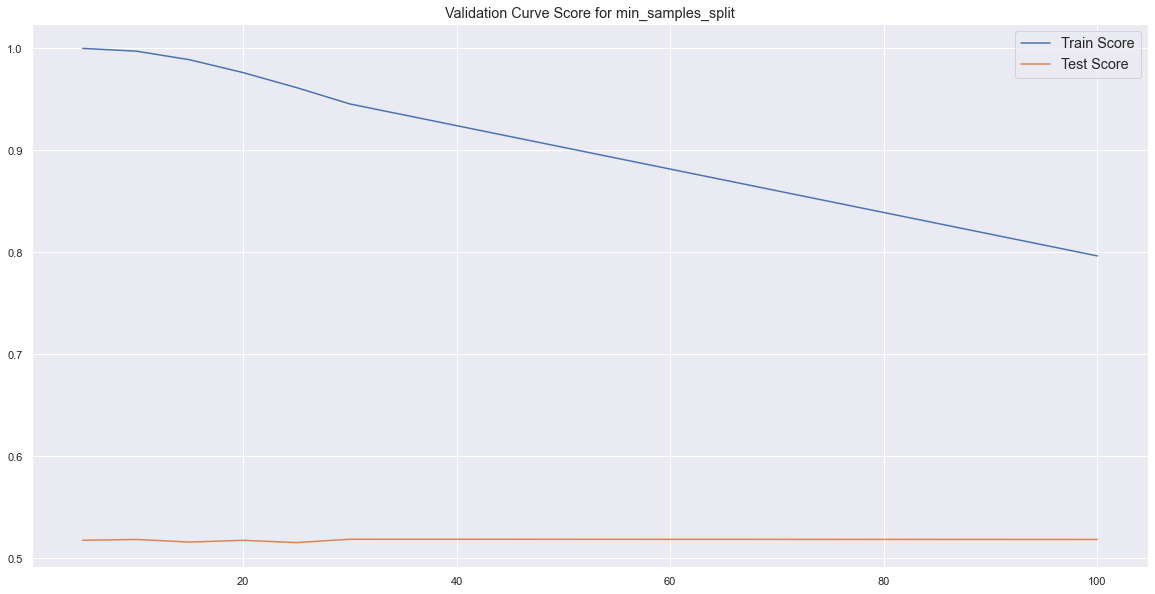

In [ ]:
#Separate between X and Y
X_train = train_data.loc[:,Target_variables]

Y_train = train_data.loc[:,['Target_Direction']]

#Create validation curve for the Random Forest Classifier
rf = RandomForestClassifier()
train_scoreNum, test_scoreNum = validation_curve(rf,
                                X = X_train.loc['2010-01-01':], y = Y_train.loc['2010-01-01':,'Target_Direction'],
                                param_name = 'min_samples_split',
                                param_range = [5,10,15,20,25,30,100], cv = TimeSeriesSplit(n_splits = 3))

train_scores_mean = np.mean(train_scoreNum, axis=1)
train_scores_std = np.std(train_scoreNum, axis=1)
test_scores_mean = np.mean(test_scoreNum, axis=1)
test_scores_std = np.std(test_scoreNum, axis=1)

plt.figure(figsize = (20,10))
plt.plot([5,10,15,20,25,30,100],train_scores_mean)
plt.plot([5,10,15,20,25,30,100],test_scores_mean)
plt.legend(['Train Score','Test Score'], fontsize = 'large')
plt.title('Validation Curve Score for min_samples_split', fontsize = 'large')



# Pickle files

Python offers a very convenient way of saving function files using the pickle package. The idea would be to fit the model on the data and save this fitted model into pickle files for each cluster. This way we would have a different model saved for each cluster. Hence, when predicting for a particular company, we will use the model in the corresponding cluster’s pickle file and make our prediction.

# Building Random Forest Model

In [ ]:
#Run the loop for every unique cluster - 17 loops
print(clusters_df.Cluster.unique())
for cluster_selected in clusters_df.Cluster.unique():

    print(f'The current cluster running is : {cluster_selected}')

    #Get data for that cluster
    co_data = all_data[all_data.Symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
    co_train = co_data.loc[:'2020-12-31']
    co_train = co_train.dropna().copy()

    X_train = co_train.loc[:,Target_variables]

    Y_train = co_train.loc[:,'Target_Direction']

    #Define paramters from Validation Curve
    params = {'max_depth': [5, 7],
          'max_features': ['sqrt'],
          'min_samples_leaf': [10, 12, 15, 17, 20],
          'n_estimators': [5, 6, 7, 8, 9],
         'min_samples_split':[20, 25, 30]} #Using Validation Curves

    rf = RandomForestClassifier()

    #Perform a TimeSeriesSplit on the dataset
    time_series_split = TimeSeriesSplit(n_splits = 3)


    rf_cv = GridSearchCV(rf, params, cv = time_series_split, n_jobs = 1, verbose = 1)

    #Fit the random forest with our X_train and Y_train
    rf_cv.fit(X_train, Y_train)

    #Save the fited variable into a Pickle file
    file_loc = f'{os.getcwd()}Cluster_{cluster_selected}'
    pickle.dump(rf_cv, open(file_loc,'wb'))

    #\\Pickle_Files\\

[0 1 2 3 4 5 6 7 8 9]
The current cluster running is : 0
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   19.2s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 1
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:  1.3min finished


The current cluster running is : 2
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   22.9s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 3
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   20.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 4
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   12.0s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 5
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   53.1s finished


The current cluster running is : 6
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   19.4s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 7
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   12.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 8
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   13.8s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


The current cluster running is : 9
Fitting 3 folds for each of 150 candidates, totalling 450 fits


[Parallel(n_jobs=1)]: Done 450 out of 450 | elapsed:   24.4s finished


# Final prediction

Now that we have a saved model for each of the clusters, we can use these models to get predictions for the stocks. The models saved contain daily data to 31st December 2020, which is a significant number of data points for a good model. One can create this model up to the most recent date as well. The reason I used 31st December 2020 is to back-test the model from 1st January 2021 to now.

# Trading : Back-test

In order to trade using this model, we would obtain a probability of an upward movement for each stock. We aim to go long on those stocks which the highest probability of up move. Let us look at an example.
Let us assume that we are currently on 31st December 2020 and have created the model files. The next trading day is 2nd January 2021. At the end of 2nd January, we now have values for all the indicators using which we can predict each stocks movement. Hence, we will put these values in our models and get the probability of 1 (up movement) in next 7 trading days for each stock .


In [ ]:
lst_days = []
for i in test_data.index:
    lst_days.append(str(i)[:10])

lst_days = list(set(lst_days))
print(lst_days)

['2021-03-31', '2021-05-24', '2021-10-19', '2021-05-20', '2021-05-31', '2021-12-28', '2021-09-21', '2021-06-21', '2022-01-26', '2021-05-14', '2021-06-14', '2021-03-08', '2021-11-04', '2021-10-06', '2021-12-14', '2021-01-20', '2021-10-07', '2021-01-06', '2021-04-19', '2021-05-28', '2021-03-26', '2021-08-20', '2021-09-10', '2021-07-28', '2021-12-03', '2021-12-29', '2021-04-23', '2021-10-22', '2021-11-15', '2021-06-03', '2021-12-27', '2022-01-24', '2021-07-21', '2021-04-14', '2021-07-06', '2021-06-15', '2021-07-20', '2021-07-23', '2021-04-05', '2021-05-10', '2021-10-25', '2021-01-19', '2021-10-29', '2021-11-01', '2021-05-25', '2021-12-24', '2021-08-23', '2022-01-12', '2021-04-13', '2022-02-07', '2021-05-06', '2021-03-05', '2022-02-11', '2021-01-07', '2021-01-27', '2021-06-29', '2021-09-20', '2022-01-06', '2021-12-02', '2021-05-12', '2022-01-13', '2021-02-09', '2021-04-28', '2021-07-15', '2021-09-29', '2021-08-06', '2021-08-13', '2021-12-06', '2021-03-17', '2021-07-27', '2021-03-25', '2021

In [ ]:
import datetime
lst_days = sorted(lst_days, key=lambda x: datetime.datetime.strptime(x, '%Y-%m-%d') , reverse=False)
len(lst_days)

280

In [ ]:
#Use 2nd January Data
# day = '2021-12-20'
lst_pred_for_tomorrow = []
for day in lst_days[:60]:
    day_data = test_data.loc[day]

    pred_for_tomorrow = pd.DataFrame({'Date':[],
                                      'company':[],
                                      'prediction':[]})

    #Predict each stock using the 2nd January Data
    for cluster_selected in clusters_df.Cluster.unique():
        rf_cv =  pickle.load(open(os.getcwd() + f'Cluster_{cluster_selected}', 'rb'))
        best_rf = rf_cv.best_estimator_
        cluster_data = day_data.loc[day_data.Symbol.isin(clusters_df.loc[clusters_df.Cluster==cluster_selected,'Companies'].tolist())].copy()
        cluster_data = cluster_data.dropna()
        if (cluster_data.shape[0]>0):
            X_test = cluster_data.loc[:,Target_variables]

            pred_for_tomorrow = pred_for_tomorrow.append(pd.DataFrame({'Date':cluster_data.index,
                                                           'company':cluster_data['Symbol'], 'prediction':best_rf.predict_proba(X_test)[:,1]}),ignore_index = True)
    lst_pred_for_tomorrow.append(pred_for_tomorrow)

In [ ]:
data_result = pd.concat(lst_pred_for_tomorrow)
len(data_result)

1740

In [ ]:
data_result

,Date,company,prediction
0,2021-01-04,PDR,0.488594
1,2021-01-04,ACB,0.515830
2,2021-01-04,BID,0.469327
3,2021-01-04,CTG,0.531032
4,2021-01-04,HDB,0.509871
...,...,...,...
24,2021-04-02,MSN,0.496111
25,2021-04-02,GVR,0.496064
26,2021-04-02,POW,0.631553
27,2021-04-02,GAS,0.506365


We now have a dataframe with the probability of up move for each stock. This can be used for trading on 3rd January.

Probability of up move for each company — Image by author
In order to find the stocks with highest probability of up move, we sort the prediction column in a descending order and pick and top 10 stocks.
Hence, once we have the 10 stocks, we will wait for 3rd January 2021 and buy at the Open price, hold for 7 days, and sell on the 7th trading day end Closing price. The main assumption here is that we can trade at the Open price and sell at the Close price. This is not too unrealistic given we know the timings of the market and can code to execute 1 minute after Opening and 1 minute before Closing of the day.

In [ ]:
final_result = []
for data in lst_pred_for_tomorrow:
    top_10_pred = data.sort_values(by = ['prediction'], ascending = False)
    # print(top_10_pred['Date'])
    day = str(list(top_10_pred['Date'])[0])
    # print(day)

    for selected_company in top_10_pred['company']:
        actual = all_data[all_data.Symbol == selected_company].loc[day,'Target_Direction']
        pct_change = all_data[all_data.Symbol == selected_company].loc[day,'Target']
        top_10_pred.loc[top_10_pred.company == selected_company,'actual'] = actual
        top_10_pred.loc[top_10_pred.company == selected_company,'pct_change'] = pct_change

    final_result.append(top_10_pred)

In [ ]:
pred_result = pd.concat(final_result)
pred_result

,Date,company,prediction,actual,pct_change
26,2021-01-04,POW,0.692778,1.0,1.792115
13,2021-01-04,NVL,0.680424,1.0,16.308075
15,2021-01-04,VJC,0.641082,1.0,4.372019
27,2021-01-04,GAS,0.551118,1.0,5.681818
8,2021-01-04,TPB,0.548962,0.0,-1.075160
...,...,...,...,...,...
6,2021-04-02,SSI,0.475140,1.0,1.714361
13,2021-04-02,NVL,0.443824,1.0,11.290620
20,2021-04-02,HPG,0.433406,1.0,1.212144
15,2021-04-02,VJC,0.392325,0.0,-3.014706


In [ ]:
# top_10_pred.to_excel("result.xlsx")

In [ ]:
ratio = 0.7

Thus, below is the table with the probability of prediction, the actual movement after 7 days and the percentage change that took place in next 7 days.

Top 10 companies in our prediction — Image by author
We can see that for 9 out of top 10 firms, the prediction was actually an up move in the next 7 trading days thus one could potentially trade on the prediction information on beginning of 3rd January 2021 and if all 10 stocks were bought, there would be a profit realized on 9 of these stocks assuming a holding period of 7 days.

In [ ]:
pred_result[pred_result['actual'] == 0]

,Date,company,prediction,actual,pct_change
8,2021-01-04,TPB,0.548962,0.0,-1.075160
26,2021-01-05,POW,0.639207,0.0,-1.045296
8,2021-01-05,TPB,0.567793,0.0,-1.073238
9,2021-01-06,VCB,0.496185,0.0,-0.770033
13,2021-01-07,NVL,0.598923,0.0,-1.103342
...,...,...,...,...,...
7,2021-04-02,TCB,0.482030,0.0,-0.239808
9,2021-04-02,VCB,0.481341,0.0,-2.499386
1,2021-04-02,ACB,0.479000,0.0,-1.983003
15,2021-04-02,VJC,0.392325,0.0,-3.014706


In [ ]:
pred_result[pred_result['actual'] == 1]

,Date,company,prediction,actual,pct_change
26,2021-01-04,POW,0.692778,1.0,1.792115
13,2021-01-04,NVL,0.680424,1.0,16.308075
15,2021-01-04,VJC,0.641082,1.0,4.372019
27,2021-01-04,GAS,0.551118,1.0,5.681818
6,2021-01-04,SSI,0.548962,1.0,0.751725
...,...,...,...,...,...
5,2021-04-02,MBB,0.483087,1.0,2.809917
8,2021-04-02,TPB,0.477799,1.0,3.315867
6,2021-04-02,SSI,0.475140,1.0,1.714361
13,2021-04-02,NVL,0.443824,1.0,11.290620


In [ ]:
pred_result[pred_result['prediction'] > ratio][pred_result[pred_result['prediction'] > ratio]['actual'] == 0]

,Date,company,prediction,actual,pct_change
27,2021-01-14,GAS,0.721870,0.0,-8.924731
27,2021-01-15,GAS,0.768207,0.0,-9.456522
15,2021-01-21,VJC,0.712992,0.0,-4.635258
18,2021-01-26,BVH,0.738777,0.0,-1.858108
0,2021-02-09,PDR,0.755710,0.0,-0.639080
0,2021-02-17,PDR,0.755710,0.0,-2.173884
14,2021-02-18,SAB,0.747934,0.0,-1.675393
0,2021-02-23,PDR,0.784333,0.0,-1.567459
0,2021-02-24,PDR,0.835389,0.0,-0.159320
12,2021-03-01,PNJ,0.752108,0.0,-1.647059


In [ ]:
pred_result[pred_result['prediction'] > ratio][pred_result[pred_result['prediction'] > ratio]['actual'] == 1]

,Date,company,prediction,actual,pct_change
15,2021-01-05,VJC,0.704964,1.0,4.643715
23,2021-01-26,VNM,0.757555,1.0,2.641509
22,2021-01-26,VIC,0.730183,1.0,3.448161
0,2021-01-26,PDR,0.712343,1.0,7.860984
18,2021-01-27,BVH,0.750358,1.0,10.091743
22,2021-01-27,VIC,0.711405,1.0,13.998712
26,2021-01-28,POW,0.743327,1.0,8.968610
22,2021-01-28,VIC,0.729664,1.0,9.189755
23,2021-01-28,VNM,0.729664,1.0,9.687500
18,2021-01-28,BVH,0.729664,1.0,12.549020


In [ ]:
pred_result[pred_result['prediction'] < ratio][pred_result[pred_result['prediction'] < ratio]['actual'] == 1]

,Date,company,prediction,actual,pct_change
26,2021-01-04,POW,0.692778,1.0,1.792115
13,2021-01-04,NVL,0.680424,1.0,16.308075
15,2021-01-04,VJC,0.641082,1.0,4.372019
27,2021-01-04,GAS,0.551118,1.0,5.681818
6,2021-01-04,SSI,0.548962,1.0,0.751725
...,...,...,...,...,...
5,2021-04-02,MBB,0.483087,1.0,2.809917
8,2021-04-02,TPB,0.477799,1.0,3.315867
6,2021-04-02,SSI,0.475140,1.0,1.714361
13,2021-04-02,NVL,0.443824,1.0,11.290620


In [ ]:
pred_result[pred_result['prediction'] < ratio][pred_result[pred_result['prediction'] < ratio]['actual'] == 0]

,Date,company,prediction,actual,pct_change
8,2021-01-04,TPB,0.548962,0.0,-1.075160
26,2021-01-05,POW,0.639207,0.0,-1.045296
8,2021-01-05,TPB,0.567793,0.0,-1.073238
9,2021-01-06,VCB,0.496185,0.0,-0.770033
13,2021-01-07,NVL,0.598923,0.0,-1.103342
...,...,...,...,...,...
7,2021-04-02,TCB,0.482030,0.0,-0.239808
9,2021-04-02,VCB,0.481341,0.0,-2.499386
1,2021-04-02,ACB,0.479000,0.0,-1.983003
15,2021-04-02,VJC,0.392325,0.0,-3.014706


In [ ]:
pred_result[pred_result['prediction'] > ratio]

,Date,company,prediction,actual,pct_change
15,2021-01-05,VJC,0.704964,1.0,4.643715
27,2021-01-14,GAS,0.721870,0.0,-8.924731
27,2021-01-15,GAS,0.768207,0.0,-9.456522
15,2021-01-21,VJC,0.712992,0.0,-4.635258
23,2021-01-26,VNM,0.757555,1.0,2.641509
18,2021-01-26,BVH,0.738777,0.0,-1.858108
22,2021-01-26,VIC,0.730183,1.0,3.448161
0,2021-01-26,PDR,0.712343,1.0,7.860984
18,2021-01-27,BVH,0.750358,1.0,10.091743
22,2021-01-27,VIC,0.711405,1.0,13.998712


In [ ]:
pred_result[pred_result['prediction'] < ratio]

,Date,company,prediction,actual,pct_change
26,2021-01-04,POW,0.692778,1.0,1.792115
13,2021-01-04,NVL,0.680424,1.0,16.308075
15,2021-01-04,VJC,0.641082,1.0,4.372019
27,2021-01-04,GAS,0.551118,1.0,5.681818
8,2021-01-04,TPB,0.548962,0.0,-1.075160
...,...,...,...,...,...
6,2021-04-02,SSI,0.475140,1.0,1.714361
13,2021-04-02,NVL,0.443824,1.0,11.290620
20,2021-04-02,HPG,0.433406,1.0,1.212144
15,2021-04-02,VJC,0.392325,0.0,-3.014706


In [ ]:
x = pred_result.copy()
x['predict'] = x['prediction'].apply(lambda x: 1 if x > ratio else 0 )
x

,Date,company,prediction,actual,pct_change,predict
26,2021-01-04,POW,0.692778,1.0,1.792115,0
13,2021-01-04,NVL,0.680424,1.0,16.308075,0
15,2021-01-04,VJC,0.641082,1.0,4.372019,0
27,2021-01-04,GAS,0.551118,1.0,5.681818,0
8,2021-01-04,TPB,0.548962,0.0,-1.075160,0
...,...,...,...,...,...,...
6,2021-04-02,SSI,0.475140,1.0,1.714361,0
13,2021-04-02,NVL,0.443824,1.0,11.290620,0
20,2021-04-02,HPG,0.433406,1.0,1.212144,0
15,2021-04-02,VJC,0.392325,0.0,-3.014706,0


In [ ]:
ratio

0.7

In [ ]:
from sklearn.metrics import classification_report
print(classification_report(x['actual'], x['predict']))

              precision    recall  f1-score   support

         0.0       0.45      0.98      0.62       783
         1.0       0.67      0.03      0.07       957

    accuracy                           0.46      1740
   macro avg       0.56      0.51      0.34      1740
weighted avg       0.57      0.46      0.32      1740

